# Emulators: Measuring performance

This example illustrates how different neural networks perform in emulating the log-likelihood surface of a time series and in Bayesian inference, using a two-step MCMC procedure with emulator neural networks [Emulated Metropolis MCMC](../sampling/first-example.ipynb).

It follows on from [Emulators: First example](../mcmc/first-example-emulator.ipynb)

Like in the first example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0] # rescaled true parameters

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("Gaussian noise:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)
values = org_values + np.random.normal(0, noise, org_values.shape)

Gaussian noise: 24.898095903089327


Using matplotlib and seaborn (optional - for styling), I look at the noisy time series I just simulated:

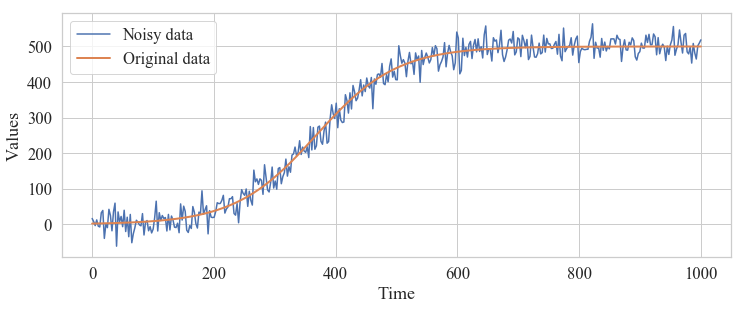

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Original data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create (rescaled) bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions, using the rescaled true parameters:

In [12]:
x0 = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

## Creating training data

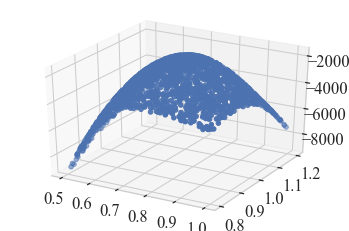

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.model_selection import train_test_split

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

## Training various NNs with different setups

In [14]:
layers = list(range(1, 7, 1))
neurons = [ 2**j for j in range(1,6+1) ]
epochs = list(range(100, 600, 100))

# Compute all possible permutations of NN parameters
hyperparams = [[i, j, k] for i in layers  
                         for j in neurons 
                         for k in epochs] 
print(len(hyperparams), "sets of hyperparameters")
print ("All possible permutations are: " + str(hyperparams)) 

180 sets of hyperparameters
All possible permutations are: [[1, 2, 100], [1, 2, 200], [1, 2, 300], [1, 2, 400], [1, 2, 500], [1, 4, 100], [1, 4, 200], [1, 4, 300], [1, 4, 400], [1, 4, 500], [1, 8, 100], [1, 8, 200], [1, 8, 300], [1, 8, 400], [1, 8, 500], [1, 16, 100], [1, 16, 200], [1, 16, 300], [1, 16, 400], [1, 16, 500], [1, 32, 100], [1, 32, 200], [1, 32, 300], [1, 32, 400], [1, 32, 500], [1, 64, 100], [1, 64, 200], [1, 64, 300], [1, 64, 400], [1, 64, 500], [2, 2, 100], [2, 2, 200], [2, 2, 300], [2, 2, 400], [2, 2, 500], [2, 4, 100], [2, 4, 200], [2, 4, 300], [2, 4, 400], [2, 4, 500], [2, 8, 100], [2, 8, 200], [2, 8, 300], [2, 8, 400], [2, 8, 500], [2, 16, 100], [2, 16, 200], [2, 16, 300], [2, 16, 400], [2, 16, 500], [2, 32, 100], [2, 32, 200], [2, 32, 300], [2, 32, 400], [2, 32, 500], [2, 64, 100], [2, 64, 200], [2, 64, 300], [2, 64, 400], [2, 64, 500], [3, 2, 100], [3, 2, 200], [3, 2, 300], [3, 2, 400], [3, 2, 500], [3, 4, 100], [3, 4, 200], [3, 4, 300], [3, 4, 400], [3, 4, 500], 

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

sigma0 = [[ 1.01547594e-05, -2.58358260e-06], [-2.58358260e-06,  1.22093040e-05]]
scaling_factors = [1/50, 500]

mapes = []
w_distances_r_nn = []
w_distances_k_nn = []
w_distances_r_emu = []
w_distances_k_emu = []
acceptance_rates1 = []
acceptance_rates2 = []

for i, p in enumerate(hyperparams):
    print("Testing NN with parameters (layers, neurons, epochs):", p)
    # Train NN with given parameters
    emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
    emu.set_parameters(layers=p[0], neurons=p[1], hidden_activation='relu', activation='linear', learning_rate=0.0001)
    hist = emu.fit(epochs=p[2], batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
    log_posterior_emu = pints.LogPosterior(emu, log_prior)
    
    # Compute mean abs. percentage error between likelihood surfaces
    test_splits = 50 # number of splits along each axis
    r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
    model_prediction = pints.predict_grid(log_likelihood, test_data)
    emu_prediction = pints.predict_grid(emu, test_data)
    mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
    mapes.append(mape)

    # Run standard Metropolis Hastings MCMC
    # Create mcmc routine
    mcmc = pints.MCMCController(log_posterior, 3, x0, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)
    mcmc.set_max_iterations(30000) # Add stopping criterion
    mcmc.set_log_to_screen(False) # Disable logging mode
    metropolis_chains = mcmc.run()
    # Revert scaling
    metropolis_chains_rescaled = np.copy(metropolis_chains)
    metropolis_chain_rescaled = metropolis_chains_rescaled[0]
    metropolis_chain_rescaled = metropolis_chain_rescaled[10000:]
    metropolis_chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] 
                                  for chain in metropolis_chains])
    metropolis_chain = metropolis_chains[0]
    metropolis_chain = metropolis_chain[10000:]
    # Check convergence using rhat criterion
    rhat = pints.rhat_all_params(metropolis_chains_rescaled[:, 10000:, :])
    
    
    # Run Metropolis Hastings MCMC using NN posterior
    # Create mcmc routine
    mcmc = pints.MCMCController(log_posterior_emu, 3, x0, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)
    mcmc.set_max_iterations(30000) # Add stopping criterion
    mcmc.set_log_to_screen(False) # Disable logging mode
    chains_emu = mcmc.run()
    # Revert scaling
    chains_emu_rescaled = np.copy(chains_emu)
    chain_emu_rescaled = chains_emu_rescaled[0]
    chain_emu_rescaled = chain_emu_rescaled[10000:]
    chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])
    chain_emu = chains_emu[0]
    chain_emu = chain_emu[10000:]
    # Check convergence using rhat criterion
    rhat = pints.rhat_all_params(chains_emu_rescaled[:, 10000:, :])
    
    
    # Run 2-step Metropolis Hastings MCMC
    # Create mcmc routine
    mcmc = pints.MCMCController(log_posterior_emu, 3, x0, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)
    mcmc.set_max_iterations(30000) # Add stopping criterion
    mcmc.set_log_to_screen(False) # Disable logging mode
    emulated_chains = mcmc.run()
    # Get acceptance rates per stage of the 2-step procedure
    rates = mcmc.acceptance_rates()
    acceptance_rates1.append(rates[0]) # Chain 1
    acceptance_rates2.append(rates[1]) # Chain 2
    # Revert scaling
    emulated_chains_rescaled = np.copy(emulated_chains)
    emulated_chain_rescaled = emulated_chains_rescaled[0]
    emulated_chain_rescaled = emulated_chain_rescaled[10000:]
    emulated_chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] 
                                for chain in emulated_chains])
    emulated_chain = emulated_chains[0]
    emulated_chain = emulated_chain[10000:]
    # Check convergence using rhat criterion
    rhat = pints.rhat_all_params(emulated_chains_rescaled[:, 10000:, :])
    
    
    # Compute Wasserstein distance
    metropolis_chain_r = np.array([sample[0] for sample in metropolis_chain])
    metropolis_chain_k = np.array([sample[1] for sample in metropolis_chain])
    chain_emu_r = np.array([sample[0] for sample in chain_emu])
    chain_emu_k = np.array([sample[1] for sample in chain_emu])
    emulated_chain_r = np.array([sample[0] for sample in emulated_chain])
    emulated_chain_k = np.array([sample[1] for sample in emulated_chain])

    w_distance1_r = stats.wasserstein_distance(metropolis_chain_r, chain_emu_r)
    w_distance1_k = stats.wasserstein_distance(metropolis_chain_k, chain_emu_k)
    w_distance2_r = stats.wasserstein_distance(metropolis_chain_r, emulated_chain_r)
    w_distance2_k = stats.wasserstein_distance(metropolis_chain_k, emulated_chain_k)
    
    w_distances_r_nn.append(w_distance1_r)
    w_distances_k_nn.append(w_distance1_k)
    w_distances_r_emu.append(w_distance2_r)
    w_distances_k_emu.append(w_distance2_k)

    print(p, mape, w_distance1_r, w_distance1_k, w_distance2_r, w_distance2_k)
    

Testing NN with parameters (layers, neurons, epochs): [1, 2, 100]
Acceptance1: 0.8082000000000009 Acceptance2: 0.5407489895240449
Acceptance1: 0.809566666666665 Acceptance2: 0.5495944332358882
Acceptance1: 0.8074666666666661 Acceptance2: 0.5403731836195522
[1, 2, 100] 0.2656820523151366 0.004765389515739623 92.18731549713615 1.1377493709411615e-06 0.041455703950735924
Testing NN with parameters (layers, neurons, epochs): [1, 2, 200]
Acceptance1: 0.7297333333333326 Acceptance2: 0.4828247761739441
Acceptance1: 0.733033333333332 Acceptance2: 0.4864717384384527
Acceptance1: 0.7325999999999989 Acceptance2: 0.47879697879697936
[1, 2, 200] 0.2630194678519531 0.0047448411512391354 96.02602839550617 1.8476228785840246e-06 0.07530980268331589
Testing NN with parameters (layers, neurons, epochs): [1, 2, 300]
Acceptance1: 0.5568333333333338 Acceptance2: 0.17228374738102395
Acceptance1: 0.5606000000000082 Acceptance2: 0.17124509454155934
Acceptance1: 0.556500000000008 Acceptance2: 0.163941299790354

Acceptance1: 0.6509333333333266 Acceptance2: 0.391079475624748
Acceptance1: 0.6541333333333395 Acceptance2: 0.3848858540562549
Acceptance1: 0.6513333333333309 Acceptance2: 0.3712896622313218
[1, 32, 300] 0.2379146170186118 0.0050892965537634475 5.8734101291371825 5.917860574090126e-06 0.13231695440308155
Testing NN with parameters (layers, neurons, epochs): [1, 32, 400]
Acceptance1: 0.6715333333333381 Acceptance2: 0.4015685495879991
Acceptance1: 0.6708333333333351 Acceptance2: 0.4096397515527936
Acceptance1: 0.6683666666666671 Acceptance2: 0.4129968580120674
[1, 32, 400] 0.2147148102257697 0.004992075872179483 11.065660335508905 2.0288014486062335e-06 0.1941481261346709
Testing NN with parameters (layers, neurons, epochs): [1, 32, 500]
Acceptance1: 0.5290333333333302 Acceptance2: 0.09627622708084006
Acceptance1: 0.5290333333333417 Acceptance2: 0.10623149139940605
Acceptance1: 0.5289999999999958 Acceptance2: 0.10226843100189098
[1, 32, 500] 0.14317508004401394 0.0002936186501167528 16.9

Acceptance1: 0.5962000000000035 Acceptance2: 0.28368556412836726
Acceptance1: 0.5993333333333307 Acceptance2: 0.28259176863181573
Acceptance1: 0.6012000000000031 Acceptance2: 0.2821579064094014
[2, 8, 500] 0.23450070878451287 0.0017939056691940512 100.97761649978371 4.827471699882255e-06 0.07976885685819168
Testing NN with parameters (layers, neurons, epochs): [2, 16, 100]
Acceptance1: 0.5757999999999958 Acceptance2: 0.2478291073289355
Acceptance1: 0.5789999999999997 Acceptance2: 0.2402417962003463
Acceptance1: 0.5780333333333312 Acceptance2: 0.247332910443459
[2, 16, 100] 0.2532652728928028 0.005090725078124056 18.981795347465887 6.900874589643191e-06 0.1416713535411358
Testing NN with parameters (layers, neurons, epochs): [2, 16, 200]
Acceptance1: 0.5830999999999973 Acceptance2: 0.2984050763162435
Acceptance1: 0.5796333333333303 Acceptance2: 0.2946115360285234
Acceptance1: 0.5863333333333385 Acceptance2: 0.2932347924957347
[2, 16, 200] 0.2392220586547369 0.005092838214181809 62.56397

Acceptance1: 0.8474666666666669 Acceptance2: 0.560612020138452
Acceptance1: 0.8477999999999999 Acceptance2: 0.5658960446646222
Acceptance1: 0.8517666666666677 Acceptance2: 0.5592689703752974
[3, 4, 200] 0.2677047539086792 0.0006874994962903846 95.35630287490902 1.9827154339232177e-06 0.06388368349991372
Testing NN with parameters (layers, neurons, epochs): [3, 4, 300]
Acceptance1: 0.6352333333333335 Acceptance2: 0.3654300257123369
Acceptance1: 0.6410000000000017 Acceptance2: 0.3658346333853347
Acceptance1: 0.6390333333333365 Acceptance2: 0.3566324135412844
[3, 4, 300] 0.2713057859088294 0.005051721943832613 97.038907311683 6.4018993511567675e-06 0.08836377615342302
Testing NN with parameters (layers, neurons, epochs): [3, 4, 400]
Acceptance1: 0.7764000000000008 Acceptance2: 0.5330585608792711
Acceptance1: 0.7776666666666672 Acceptance2: 0.5286326618088293
Acceptance1: 0.7728999999999993 Acceptance2: 0.5306421701815672
[3, 4, 400] 0.23586197755576435 0.005042374555469615 96.002833275540

Acceptance1: 0.5305333333333302 Acceptance2: 0.44621764262377717
Acceptance1: 0.5228333333333335 Acceptance2: 0.3231112527892888
Acceptance1: 0.5220000000000068 Acceptance2: 0.2880587484035704
[3, 64, 400] 0.04343469699730549 3.394222614130793e-05 2.5625340997825123 2.0767291538647683e-06 0.08306201306808308
Testing NN with parameters (layers, neurons, epochs): [3, 64, 500]
Acceptance1: 0.5869666666666707 Acceptance2: 0.3210858083934317
Acceptance1: 0.5809333333333382 Acceptance2: 0.3079527197613009
Acceptance1: 0.5608999999999966 Acceptance2: 0.2646342188149999
[3, 64, 500] 0.030968620105964437 0.0001757331748379574 3.3655497818746793 7.908254366769758e-06 0.11409505625304135
Testing NN with parameters (layers, neurons, epochs): [4, 2, 100]
Acceptance1: 0.7776000000000013 Acceptance2: 0.5306498628257879
Acceptance1: 0.7768333333333322 Acceptance2: 0.5255953658013304
Acceptance1: 0.7774333333333331 Acceptance2: 0.5223599022424232
[4, 2, 100] 0.2620565627401756 0.005032026443537945 97.8

Acceptance1: 0.5053666666666601 Acceptance2: 0.08713145570872757
Acceptance1: 0.5120999999999978 Acceptance2: 0.06808566035279565
Acceptance1: 0.5169666666666685 Acceptance2: 0.07582693919659571
[4, 32, 100] 0.043607464006088094 0.0001775222868641827 9.950492258856153 5.3699783307232715e-06 0.5443045599342291
Testing NN with parameters (layers, neurons, epochs): [4, 32, 200]
Acceptance1: 0.5608666666666631 Acceptance2: 0.44514441935100485
Acceptance1: 0.5596666666666654 Acceptance2: 0.4497915425848772
Acceptance1: 0.5553666666666655 Acceptance2: 0.42080307304483533
[4, 32, 200] 0.012914519355873478 4.484631297787602e-05 8.736149459096051 1.3429976694417673e-06 0.080488859330381
Testing NN with parameters (layers, neurons, epochs): [4, 32, 300]
Acceptance1: 0.5588666666666741 Acceptance2: 0.5434212095908334
Acceptance1: 0.5561999999999986 Acceptance2: 0.5386551600143908
Acceptance1: 0.5494333333333384 Acceptance2: 0.4214645392222262
[4, 32, 300] 0.01452521445677568 0.0001893517243344584

Acceptance1: 0.4920666666666674 Acceptance2: 0.3341010703156738
Acceptance1: 0.495900000000004 Acceptance2: 0.26430059823889024
Acceptance1: 0.48743333333333433 Acceptance2: 0.32790808999521553
[5, 8, 300] 0.04311006498593928 4.202014296424745e-05 3.119113161837426 3.1193819388689474e-06 0.3702221734594526
Testing NN with parameters (layers, neurons, epochs): [5, 8, 400]
Acceptance1: 0.6022999999999971 Acceptance2: 0.3481653660966319
Acceptance1: 0.6323000000000032 Acceptance2: 0.39058463809373006
Acceptance1: 0.5908000000000008 Acceptance2: 0.3298352516362005
[5, 8, 400] 0.04458726877334102 0.0005910488555911992 15.871037126565557 7.793982111067064e-06 0.04426168991168875
Testing NN with parameters (layers, neurons, epochs): [5, 8, 500]
Acceptance1: 0.5285333333333382 Acceptance2: 0.09497981836528684
Acceptance1: 0.5288333333333309 Acceptance2: 0.09751024267255026
Acceptance1: 0.5161333333333329 Acceptance2: 0.1035908034099714
[5, 8, 500] 0.027720143696226593 0.0002354441155324864 15.

Acceptance1: 0.9625666666666665 Acceptance2: 0.5673373272846919
Acceptance1: 0.9660333333333335 Acceptance2: 0.5623339429281237
Acceptance1: 0.9651 Acceptance2: 0.5680931164300776
[6, 2, 500] 0.2718929381692955 0.00408448912014309 76.38211161275902 2.821960685311946e-06 0.058867266833563095
Testing NN with parameters (layers, neurons, epochs): [6, 4, 100]
Acceptance1: 0.6095333333333282 Acceptance2: 0.31379197200044
Acceptance1: 0.6081999999999977 Acceptance2: 0.307629069385072
Acceptance1: 0.6086666666666742 Acceptance2: 0.29852135815990954
[6, 4, 100] 0.26918712844986087 0.005086097483025107 97.15072243794404 6.777045381648589e-06 0.11052917266803372
Testing NN with parameters (layers, neurons, epochs): [6, 4, 200]
Acceptance1: 0.6964000000000025 Acceptance2: 0.45333141872487176
Acceptance1: 0.6843666666666683 Acceptance2: 0.4360722809410117
Acceptance1: 0.6850666666666684 Acceptance2: 0.4454067730634489
[6, 4, 200] 0.10711894812615778 0.0011748720561361315 65.45771645294977 2.428799

Acceptance1: 0.5376000000000054 Acceptance2: 0.3813864087301558
Acceptance1: 0.5461000000000097 Acceptance2: 0.36428004638954403
Acceptance1: 0.5358999999999976 Acceptance2: 0.17808048765317055
[6, 64, 200] 0.020203445233533845 1.3689557590706006e-05 3.985351151783576 6.2998373162934195e-06 0.1763228152781139
Testing NN with parameters (layers, neurons, epochs): [6, 64, 300]
Acceptance1: 0.5573333333333372 Acceptance2: 0.3124999999999971
Acceptance1: 0.5510333333333313 Acceptance2: 0.3112939326114582
Acceptance1: 0.5522000000000014 Acceptance2: 0.21067246166847686
[6, 64, 300] 0.017002212641543807 5.8515451826272995e-05 5.936865936210255 1.5511743162355013e-06 0.15972363302277065
Testing NN with parameters (layers, neurons, epochs): [6, 64, 400]
Acceptance1: 0.5833666666666694 Acceptance2: 0.6695045997371554
Acceptance1: 0.5843999999999974 Acceptance2: 0.6727127538215869
Acceptance1: 0.5700000000000018 Acceptance2: 0.41847953216374206
[6, 64, 400] 0.011096091734477972 4.519789795571092

In [25]:
mapes[:5]

[0.2656820523151366,
 0.2630194678519531,
 0.2628358003176474,
 0.26066968050024364,
 0.27126604172487984]

In [26]:
w_distances_r_emu[:5]

[1.1377493709411615e-06,
 1.8476228785840246e-06,
 6.614237150605686e-06,
 5.142894922268239e-06,
 8.808965892826199e-06]

In [28]:
w_distances_k_emu[:5]

[0.041455703950735924,
 0.07530980268331589,
 0.19523773461730726,
 0.14246210527908976,
 0.17274481164218553]

In [27]:
acceptance_rates2[:5]
#self._acceptance, self._acceptance1, self._acceptance2

[(0.44493333333333296, 0.809566666666665, 0.5495944332358882),
 (0.3565999999999998, 0.733033333333332, 0.4864717384384527),
 (0.09599999999999957, 0.5606000000000082, 0.17124509454155934),
 (0.34856666666666564, 0.7229666666666652, 0.48213380054405414),
 (0.17446666666666732, 0.6020333333333378, 0.28979569237583647)]

In [74]:
chain1_acceptance_rates2 = [r[2] for r in acceptance_rates1]
chain2_acceptance_rates2 = [r[2] for r in acceptance_rates2]
chain1_acceptance_rates2[:5]

[0.5407489895240449,
 0.4828247761739441,
 0.17228374738102395,
 0.4751713915137991,
 0.28254160696572395]

In [75]:
# Sort according to MAPEs
idx = np.array(mapes).argsort()
acceptance2_sorted1 = np.array(chain1_acceptance_rates2)[idx]
acceptance2_sorted2 = np.array(chain2_acceptance_rates2)[idx]

w_distances_k_sorted = np.array(w_distances_k_emu)[idx]
w_distances_r_sorted = np.array(w_distances_r_emu)[idx]
mapes_sorted = np.array(mapes)[idx]

#mean_acceptance2 = [np.mean(r[0]+r[1]+r[2]) for r in acceptance_rates2]
#mean_acceptance2_sorted = np.array(mean_acceptance2)[idx]

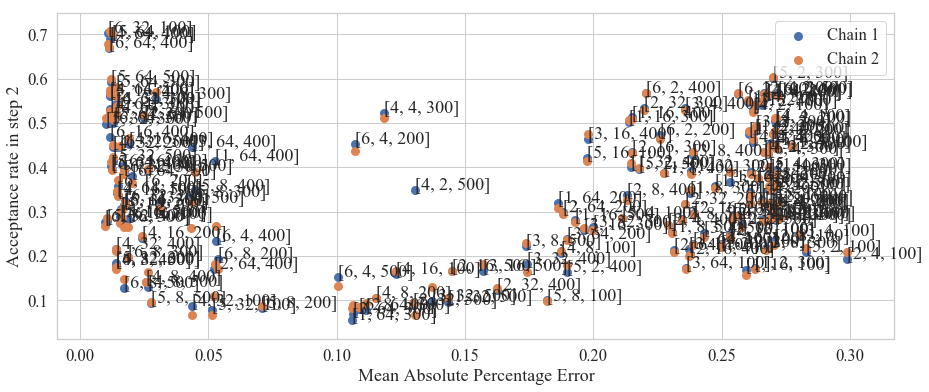

In [85]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Mean Absolute Percentage Error')
plt.ylabel('Acceptance rate in step 2')
ax.scatter(mapes, chain1_acceptance_rates2, lw=3, label='Chain 1')
ax.scatter(mapes, chain2_acceptance_rates2, lw=3, label='Chain 2')
#plt.plot(mapes, w_distances_k_sorted, lw=2, label='Wasserstein distance of samples')
#hyperparams_sorted = np.array(hyperparams)[idx]
for i, txt in enumerate(hyperparams):
    ax.annotate(txt, (mapes[i], chain1_acceptance_rates2[i]))
plt.legend()
plt.show()

fig.savefig("figures/nn-comparisons/mae-many-epochs.png", bbox_inches='tight', dpi=600)

In [83]:
scaler_r = MinMaxScaler()
w_distances_r = scaler_r.fit_transform(np.array(w_distances_r_nn).reshape(-1, 1))

scaler_k = MinMaxScaler()
w_distances_k = scaler_k.fit_transform(np.array(w_distances_k_nn).reshape(-1, 1))

w_distances_sum = [r+k for r, k in zip(w_distances_r, w_distances_k)]
w_distances_sum[:5]

[array([1.83807141]),
 array([1.8718554]),
 array([1.70593268]),
 array([1.8810066]),
 array([1.97054249])]

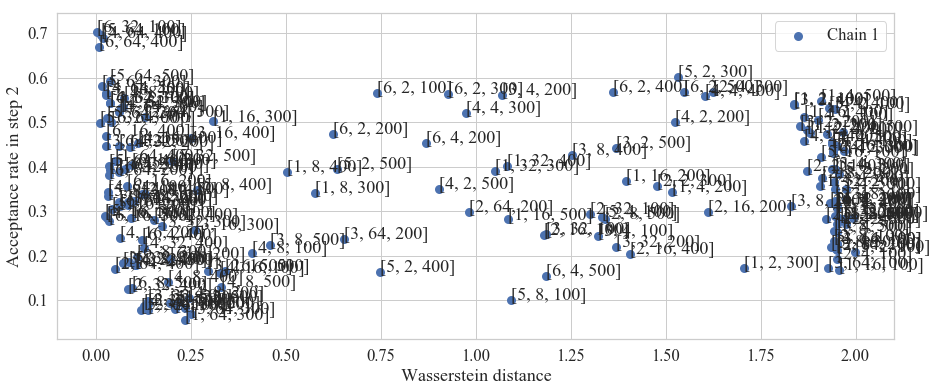

In [86]:
sns.set(context='notebook', style='whitegrid', palette='deep', font='Times New Roman', 
        font_scale=1.5, color_codes=True, rc={"grid.linewidth": 1})
fig, ax = plt.subplots(figsize=(15,6))
plt.xlabel('Wasserstein distance')
plt.ylabel('Acceptance rate in step 2')
ax.scatter(w_distances_sum, chain1_acceptance_rates2, lw=3, label='Chain 1')
#ax.scatter(mapes, chain2_acceptance_rates2, lw=3, label='Chain 2')
#plt.plot(mapes, w_distances_k_sorted, lw=2, label='Wasserstein distance of samples')
#hyperparams_sorted = np.array(hyperparams)[idx]
for i, txt in enumerate(hyperparams):
    ax.annotate(txt, (w_distances_sum[i], chain1_acceptance_rates2[i]))
plt.legend()
plt.show()

fig.savefig("figures/nn-comparisons/wasserstein-many-epochs.png", bbox_inches='tight', dpi=600)